In [24]:
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
from sklearn.preprocessing import StandardScaler
import pandas as pd
from sklearn.metrics import davies_bouldin_score
import numpy as np


In [71]:
final_movie_data = pd.read_csv('data/movies_with_tmdb_features_and_tags.csv')

movie_titles = final_movie_data[['movieId', 'title']]



In [26]:
# drop the title, movieId, revenue and budget column
final_movie_data = final_movie_data.drop(['title', 'spoken_languages', 'revenue', 'budget'], axis=1)

In [27]:
print(final_movie_data.head())

   movieId  popularity  vote_average  vote_count  runtime release_date  \
0        1     134.972          8.00       18317       81   1995-10-30   
1        2      15.958          7.24       10465      104   1995-12-15   
2        3      21.540          6.50         375      101   1995-12-22   
3        4      15.297          6.30         162      127   1995-12-22   
4        5      35.745          6.20         725      106   1995-12-08   

           production_countries  adult  \
0  ['United States of America']  False   
1  ['United States of America']  False   
2  ['United States of America']  False   
3  ['United States of America']  False   
4  ['United States of America']  False   

                                        genres          tag  
0  Adventure|Animation|Children|Comedy|Fantasy         toys  
1                   Adventure|Children|Fantasy    adventure  
2                               Comedy|Romance  good sequel  
3                         Comedy|Drama|Romance        

# Performing the clustering on the dataset

In [28]:
unique_genres = final_movie_data['genres'].str.split('|').explode().unique()
print(unique_genres)

['Adventure' 'Animation' 'Children' 'Comedy' 'Fantasy' 'Romance' 'Drama'
 'Action' 'Crime' 'Thriller' 'Horror' 'Mystery' 'Sci-Fi' 'IMAX'
 'Documentary' 'War' 'Musical' 'Western' 'Film-Noir' '(no genres listed)']


In [29]:
empty_rows_count = final_movie_data[final_movie_data['production_countries'] == '[]'].shape[0]
print(f"Number of rows where countries is an empty list: {empty_rows_count}")


final_movie_data = final_movie_data[final_movie_data['production_countries'].apply(lambda x: x != '[]')]

# Reset index if needed
final_movie_data.reset_index(drop=True, inplace=True)

empty_rows_count = final_movie_data[final_movie_data['production_countries'] == '[]'].shape[0]
print(f"Number of rows where countries is an empty list: {empty_rows_count}")


Number of rows where countries is an empty list: 834
Number of rows where countries is an empty list: 0


In [30]:

country_to_continent = {
    # North America
    'United States of America': 'North America', 'Canada': 'North America', 'Mexico': 'North America', 'Bahamas': 'North America',
    'Dominican Republic': 'North America', 'Cuba': 'North America', 'Puerto Rico': 'North America', 
    # South America
    'Brazil': 'South America', 'Argentina': 'South America', 'Chile': 'South America', 'Peru': 'South America', 
    'Colombia': 'South America', 'Uruguay': 'South America', 'Venezuela': 'South America', 'Paraguay': 'South America', 
    # Europe
    'Germany': 'Europe', 'United Kingdom': 'Europe', 'France': 'Europe', 'Italy': 'Europe', 'Spain': 'Europe', 
    'Netherlands': 'Europe', 'Belgium': 'Europe', 'Switzerland': 'Europe', 'Sweden': 'Europe', 'Portugal': 'Europe',
    'Austria': 'Europe', 'Denmark': 'Europe', 'Ireland': 'Europe', 'Norway': 'Europe', 'Poland': 'Europe', 
    'Finland': 'Europe', 'Greece': 'Europe', 'Hungary': 'Europe', 'Czech Republic': 'Europe', 'Slovakia': 'Europe', 
    'Iceland': 'Europe', 'Russia': 'Europe', 'Serbia and Montenegro': 'Europe', 'Macedonia': 'Europe',
    'Bulgaria': 'Europe', 'Yugoslavia': 'Europe', 'Luxembourg': 'Europe', 'Ukraine': 'Europe', 'Romania': 'Europe', 
    'Estonia': 'Europe', 'Lithuania': 'Europe', 'Albania': 'Europe', 'Latvia': 'Europe', 'Slovenia': 'Europe', 
    # Asia
    'China': 'Asia', 'Japan': 'Asia', 'India': 'Asia', 'South Korea': 'Asia', 'Iran': 'Asia', 'Thailand': 'Asia', 
    'Hong Kong': 'Asia', 'Malaysia': 'Asia', 'Taiwan': 'Asia', 'Philippines': 'Asia', 'Turkey': 'Asia', 'Israel': 'Asia',
    'Vietnam': 'Asia', 'Indonesia': 'Asia', 'Singapore': 'Asia', 'Jordan': 'Asia', 'Lebanon': 'Asia', 
    'Bangladesh': 'Asia', 'Pakistan': 'Asia', 'Sri Lanka': 'Asia', 'Saudi Arabia': 'Asia', 'Afghanistan': 'Asia', 
    'Kuwait': 'Asia', 'United Arab Emirates': 'Asia', 'Qatar': 'Asia', 'Myanmar': 'Asia', 'Kazakhstan': 'Asia', 
    # Africa
    'South Africa': 'Africa', 'Egypt': 'Africa', 'Morocco': 'Africa', 'Tunisia': 'Africa', 'Algeria': 'Africa', 
    'Cameroon': 'Africa', 'Senegal': 'Africa', 'Burkina Faso': 'Africa', 'Zimbabwe': 'Africa', 'Ivory Coast': 'Africa', 
    'Libya': 'Africa', 'Nigeria': 'Africa', 'Kenya': 'Africa', 'Uganda': 'Africa', 'Angola': 'Africa', 
    'Mali': 'Africa', 'Niger': 'Africa', 'Ghana': 'Africa', 'Rwanda': 'Africa', 'Ethiopia': 'Africa', 
    # Oceania
    'Australia': 'Oceania', 'New Zealand': 'Oceania', 'Papua New Guinea': 'Oceania', 'Solomon Islands': 'Oceania', 
    # For other countries not listed, include as needed
}




In [31]:
import ast


continents = ['North America', 'South America', 'Europe', 'Asia', 'Africa', 'Oceania']
for continets in continents:
    final_movie_data[continets] = 0

for i, row in final_movie_data.iterrows():
    countries = row['production_countries']
    if isinstance(countries, str):
        countries = ast.literal_eval(countries)
    for country in countries:
        continent = country_to_continent.get(country, None)

        if continent: 
            final_movie_data.at[i, continent] = 1

In [32]:
final_movie_data = final_movie_data.drop(['production_countries'], axis=1)

In [33]:
# converting the release_date to a numerical feature
# We choose to convert the release date to a numerical feature represented by the hours from the first movie's release date.
# We made this decision instead of saving the dates as year and month column. 
# The reason is that we would like to capture the time difference between the movies rather than seasonal or yearly patterns.
final_movie_data['release_date'] = pd.to_datetime(final_movie_data['release_date'])
first_release_date = final_movie_data['release_date'].min()
final_movie_data['release_date'] = (final_movie_data['release_date'] - first_release_date).dt.total_seconds() / (60 * 60 * 24)


# hot-k encoding for 'genres' column
# We felt that the genre feature was so important that we transformed it into a one-hot encoding format.
# This way, we can use the genre information in the clustering process.
# Step 1: Create a separate column for each genre
for genre in unique_genres:
    # Check if each genre is in the 'genre' column and create a binary column
    final_movie_data[genre] = final_movie_data['genres'].apply(lambda x: 1 if genre in x.split('|') else 0)

# Drop the original 'genre' column if needed
final_movie_data = final_movie_data.drop(columns=['genres'])


# We transformed the 'adult' column into a binary column.

final_movie_data['adult'] = final_movie_data['adult'].apply(lambda x: 1 if x == 'True' else 0)



In [34]:
print(final_movie_data.columns)

Index(['movieId', 'popularity', 'vote_average', 'vote_count', 'runtime',
       'release_date', 'adult', 'tag', 'North America', 'South America',
       'Europe', 'Asia', 'Africa', 'Oceania', 'Adventure', 'Animation',
       'Children', 'Comedy', 'Fantasy', 'Romance', 'Drama', 'Action', 'Crime',
       'Thriller', 'Horror', 'Mystery', 'Sci-Fi', 'IMAX', 'Documentary', 'War',
       'Musical', 'Western', 'Film-Noir', '(no genres listed)'],
      dtype='object')


In [35]:
# We will use the following features for clustering

features = ['popularity', 'vote_average', 'vote_count', 'runtime',
       'release_date', 'adult', 'North America', 'South America', 'Europe', 'Asia', 'Africa',
       'Oceania', 'Adventure', 'Animation', 'Children', 'Comedy', 'Fantasy',
       'Romance', 'Drama', 'Action', 'Crime', 'Thriller', 'Horror', 'Mystery',
       'Sci-Fi', 'IMAX', 'Documentary', 'War', 'Musical', 'Western',
       'Film-Noir', '(no genres listed)']

In [36]:
# We will apply scaling to the features
scaler = StandardScaler()
final_movie_data_scaled = final_movie_data.copy()
final_movie_data_scaled[features] = scaler.fit_transform(final_movie_data[features])

In [37]:
# Using KMeans clustering
# Define the model
kmeans = KMeans(n_clusters=28, random_state=0)

# Fit the model
kmeans.fit(final_movie_data_scaled[features])


KMeans(n_clusters=28, random_state=0)

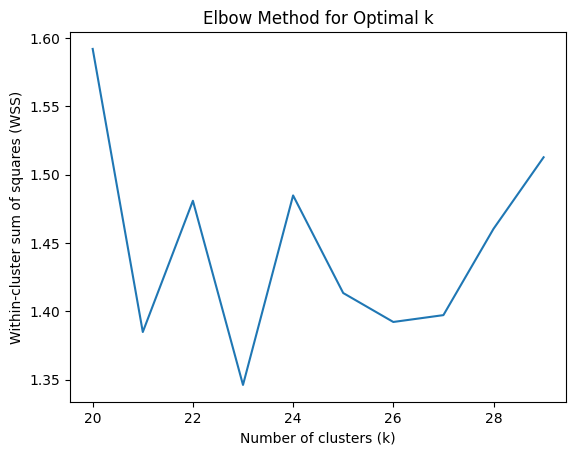

In [38]:
import matplotlib.pyplot as plt

wss = []
k_range = range(20, 30)  # Test for k from 1 to 10
for k in k_range:
    kmeans = KMeans(n_clusters=k)
    kmeans.fit(final_movie_data_scaled[features])
    score = davies_bouldin_score(final_movie_data_scaled[features], kmeans.labels_)
    wss.append(score)

plt.plot(k_range, wss)
plt.title("Elbow Method for Optimal k")
plt.xlabel("Number of clusters (k)")
plt.ylabel("Within-cluster sum of squares (WSS)")
plt.show()

In [39]:
hierarchical = AgglomerativeClustering(n_clusters=28)
hierarchical.fit(final_movie_data_scaled[features])

AgglomerativeClustering(n_clusters=28)

In [40]:
# Using DBSCAN clustering
# Define the model
dbscan = DBSCAN(eps=0.8, min_samples=10)
dbscan.fit(final_movie_data_scaled[features])

DBSCAN(eps=0.8, min_samples=10)

In [41]:


# Evaluate the clustering results
db_kmeans = davies_bouldin_score(final_movie_data_scaled[features], kmeans.labels_)
db_hierarchical = davies_bouldin_score(final_movie_data_scaled[features], hierarchical.labels_)
db_dbscan = davies_bouldin_score(final_movie_data_scaled[features], dbscan.labels_)

print(f"Davies-Bouldin Index for KMeans: {db_kmeans}")
print(f"Davies-Bouldin Index for Hierarchical Clustering: {db_hierarchical}")
print(f"Davies-Bouldin Index for DBSCAN: {db_dbscan}")

Davies-Bouldin Index for KMeans: 1.5127065055970397
Davies-Bouldin Index for Hierarchical Clustering: 1.3661604296242842
Davies-Bouldin Index for DBSCAN: 1.5802672607908477


In [42]:
# Getting the number of elements in each cluster
cluster_counts = pd.Series(kmeans.labels_).value_counts()
print(cluster_counts)
print(len(cluster_counts))

10    2410
17    2301
5     1733
14    1603
9     1462
4     1253
0     1147
20    1144
3     1084
23    1074
28    1044
1     1019
6      859
12     831
24     825
7      814
22     762
27     636
11     635
25     579
8      454
18     446
16     338
19     327
2      280
26     251
15     209
13     191
21     190
Name: count, dtype: int64
29


In [43]:
cluster_counts = pd.Series(dbscan.labels_).value_counts()
print(cluster_counts)
print(len(cluster_counts))

-1      12906
 5       1635
 19      1321
 2       1242
 20       819
        ...  
 107       10
 102       10
 79        10
 93         8
 94         8
Name: count, Length: 118, dtype: int64
118


In [44]:
# Add the preferred cluster labels to the final_movie_data dataframe
final_movie_data['cluster'] = kmeans.labels_

# Find closest movies

In [45]:
# Cosine similarity
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.neighbors import NearestNeighbors


def closest_by_cosine(data, target_point, n_neighbors=5):
    data_array = data.values  # Convert DataFrame to NumPy array
    similarities = cosine_similarity(data_array, target_point.reshape(1, -1)).flatten()
    closest_indices = np.argsort(similarities)[-n_neighbors:][::-1]  # Sort by descending similarity
    return data.iloc[closest_indices], similarities[closest_indices]  # Use .iloc to return DataFrame rows

# KD-Tree
def closest_with_kdtree(data, target_point, n_neighbors=5):
    data_array = data.values  # Convert DataFrame to NumPy array
    nbrs = NearestNeighbors(n_neighbors=n_neighbors, algorithm='kd_tree').fit(data_array)
    distances, indices = nbrs.kneighbors(target_point.reshape(1, -1))
    return data.iloc[indices[0]], distances[0]  # Use .iloc for rows

# Euclidean Distance
def closest_by_euclidean(data, target_point, n_neighbors=5):
    data_array = data.values  # Convert DataFrame to NumPy array
    distances = np.linalg.norm(data_array - target_point, axis=1)
    closest_indices = np.argsort(distances)[:n_neighbors]  # Sort by ascending distance
    return data.iloc[closest_indices], distances[closest_indices]  # Use .iloc for rows

In [46]:
movie_id = 2
cluster_recommendation = (final_movie_data.loc[final_movie_data['movieId'] == movie_id, 'cluster'].values)[0]

In [59]:
movies_cluster = final_movie_data.loc[(final_movie_data['cluster'] == cluster_recommendation) & (final_movie_data['movieId'] != 2), features]
rec_movie = final_movie_data.loc[final_movie_data['movieId'] == movie_id, features].values.flatten()

points, dist = closest_by_cosine(movies_cluster, rec_movie)
print(points.index)

points, dist = closest_with_kdtree(movies_cluster, rec_movie)
print(points.index)

points, dist = closest_by_euclidean(movies_cluster, rec_movie)
print(points.index)


Index([876, 910, 1080, 6838, 2891], dtype='int64')
Index([2891, 6838, 10742, 6456, 575], dtype='int64')
Index([2891, 6838, 10742, 6456, 575], dtype='int64')


In [74]:

movieIds = final_movie_data.loc[points.index]["movieId"].values

movie_titles = movie_titles[movie_titles['movieId'].isin(movieIds)]["title"]
print(movie_titles)

575              Métisse (Café au Lait) (1993)
2891                    Battling Butler (1926)
6456             Honeymoon Killers, The (1970)
6838               Hercules in New York (1970)
10742    Good Old Daze (Le péril jeune) (1994)
Name: title, dtype: object
